<a href="https://colab.research.google.com/github/AlexLiang230410/nem-battery-arbitrage/blob/main/notebooks/02_threshold_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%cd /content/nem-battery-arbitrage

import battery_core
import inspect

print("simulate_arbitrage signature:")
print(inspect.signature(battery_core.simulate_arbitrage))

print("\nadaptive_threshold_search signature:")
print(inspect.signature(battery_core.adaptive_threshold_search))

/content
simulate_arbitrage signature:
(price_df: pandas.core.frame.DataFrame, dt_mins: float, power_mw: float, energy_mwh: float, charge_threshold: float, discharge_threshold: float, efficiency: float, show_progress: bool = False) -> pandas.core.frame.DataFrame

adaptive_threshold_search signature:
(price_df: pandas.core.frame.DataFrame, dt_mins: float, power_mw: float, energy_mwh: float, charge_threshold_range: Iterable[float], discharge_threshold_range: Iterable[float], efficiency: float, show_progress: bool = True, min_spread: float = 0.0) -> Tuple[pandas.core.frame.DataFrame, Dict[str, Any]]


In [ ]:
# Cell 1: imports and base configuration (same parameters as baseline)

from battery_core import (
    simulate_arbitrage,
    summarize_performance,
    grid_search_thresholds,
    adaptive_threshold_search,
)
from data_utils import load_price_range

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # for heatmap

# User-configurable parameters (copied from baseline notebook)
region = "VIC1"
start_year = 2024
start_month = 12
end_year = 2025
end_month = 11
dt_mins = 5
power_mw = 10
energy_mwh = 20
charge_threshold = 30      # baseline values (for later comparison)
discharge_threshold = 70
efficiency = 0.85
visualization_year = 2025
visualization_month = 11

data_dir = "data/aemo_price_and_demand"


In [ ]:
# Cell 2: load price data for the search period

price_df = load_price_range(
    region=region,
    start_year=start_year,
    start_month=start_month,
    end_year=end_year,
    end_month=end_month,
    data_dir=data_dir,
)

print("Loaded price data:")
print("  shape:", price_df.shape)
print("  index range:", price_df.index.min(), "→", price_df.index.max())
display(price_df.head())
display(price_df.tail())


Loaded price data:
  shape: (105120, 1)
  index range: 2024-12-01 00:05:00 → 2025-12-01 00:00:00


,price
SETTLEMENTDATE,
2024-12-01 00:05:00,91.84
2024-12-01 00:10:00,91.37
2024-12-01 00:15:00,95.07
2024-12-01 00:20:00,89.65
2024-12-01 00:25:00,90.03


,price
SETTLEMENTDATE,
2025-11-30 23:40:00,-3.7
2025-11-30 23:45:00,-3.7
2025-11-30 23:50:00,-3.7
2025-11-30 23:55:00,-3.7
2025-12-01 00:00:00,-3.7


In [ ]:
# Cell 3: define search ranges for charge and discharge thresholds

charge_threshold_range = np.arange(-100, 101, 20)   # from -100 to +100, step 20
discharge_threshold_range = np.arange(20, 201, 20)  # from 20 to 200, step 20

print("Charge threshold candidates:", charge_threshold_range[:5], "...", charge_threshold_range[-5:])
print("Discharge threshold candidates:", discharge_threshold_range[:5], "...", discharge_threshold_range[-5:])
print("Total combinations (before filtering ct < dt):",
      len(charge_threshold_range) * len(discharge_threshold_range))


Charge threshold candidates: [-100  -80  -60  -40  -20] ... [ 20  40  60  80 100]
Discharge threshold candidates: [ 20  40  60  80 100] ... [120 140 160 180 200]
Total combinations (before filtering ct < dt): 110


In [ ]:
n_charge = len(charge_threshold_range)
n_discharge = len(discharge_threshold_range)

print("n_charge =", n_charge)
print("n_discharge =", n_discharge)
print("naive combinations =", n_charge * n_discharge)


n_charge = 11
n_discharge = 10
naive combinations = 110


In [ ]:
# Cell 4: run grid search over threshold combinations

grid_search_df, best_params = adaptive_threshold_search(
    price_df=price_df,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    charge_threshold_range=charge_threshold_range,
    discharge_threshold_range=discharge_threshold_range,
    efficiency=efficiency,
    show_progress=True,
)

print("Grid search completed.")
print("Number of evaluated combinations:", len(grid_search_df))
display(grid_search_df.head())


Grid search:   0%|          | 0/95 [00:00<?, ?it/s]

Grid search completed.
Number of evaluated combinations: 95


,charge_threshold,discharge_threshold,total_revenue
0,-100.0,20.0,38607.876844
1,-100.0,40.0,38862.568195
2,-100.0,60.0,40047.200523
3,-100.0,80.0,38483.697209
4,-100.0,100.0,35690.004302


In [ ]:
# Cell 5: inspect best-performing thresholds and compare with baseline

print("Best parameters found by grid search:")
for k, v in best_params.items():
    print(f"  {k}: {v}")

# Compute baseline performance (using your original thresholds)
baseline_result = simulate_arbitrage(
    price_df=price_df,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    charge_threshold=charge_threshold,
    discharge_threshold=discharge_threshold,
    efficiency=efficiency,
)
baseline_summary = summarize_performance(
    result_df=baseline_result,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    print_summary=False,
)

# Compute optimal performance
optimal_result = simulate_arbitrage(
    price_df=price_df,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    charge_threshold=best_params["charge_threshold"],
    discharge_threshold=best_params["discharge_threshold"],
    efficiency=efficiency,
)
optimal_summary = summarize_performance(
    result_df=optimal_result,
    dt_mins=dt_mins,
    power_mw=power_mw,
    energy_mwh=energy_mwh,
    print_summary=False,
)

print("\n=== Revenue comparison (baseline vs optimal) ===")
print(f"Baseline thresholds:  charge={charge_threshold}, discharge={discharge_threshold}")
print(f"  Baseline total revenue (AUD): {baseline_summary['total_revenue']:.2f}")

print(f"\nOptimal thresholds:   charge={best_params['charge_threshold']}, "
      f"discharge={best_params['discharge_threshold']}")
print(f"  Optimal total revenue (AUD):  {optimal_summary['total_revenue']:.2f}")


Best parameters found by grid search:
  charge_threshold: 40.0
  discharge_threshold: 60.0
  total_revenue: 785865.7427863316

=== Revenue comparison (baseline vs optimal) ===
Baseline thresholds:  charge=30, discharge=70
  Baseline total revenue (AUD): 778604.66

Optimal thresholds:   charge=40.0, discharge=60.0
  Optimal total revenue (AUD):  785865.74


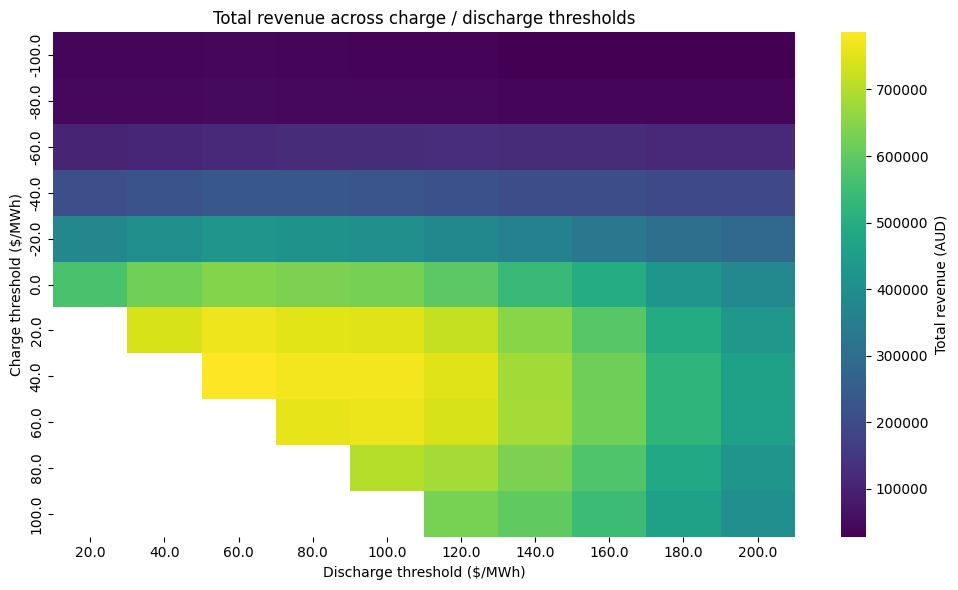

In [ ]:
# Cell 6: visualise total revenue as a heatmap over thresholds

# Pivot to 2D matrix: rows = charge_threshold, columns = discharge_threshold
pivot_df = grid_search_df.pivot(
    index="charge_threshold",
    columns="discharge_threshold",
    values="total_revenue",
)

plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_df,
    cmap="viridis",  # default colormap
    cbar_kws={"label": "Total revenue (AUD)"},
)

plt.title("Total revenue across charge / discharge thresholds")
plt.xlabel("Discharge threshold ($/MWh)")
plt.ylabel("Charge threshold ($/MWh)")

plt.tight_layout()
plt.show()


In [ ]:
# Cell 7 (optional): inspect time series under optimal thresholds

vis_start = pd.Timestamp(
    year=visualization_year,
    month=visualization_month,
    day=1,
)
vis_end = vis_start + pd.DateOffset(months=1)

optimal_window = optimal_result.loc[vis_start:vis_end].copy()

print(f"Optimal scenario window: {vis_start} → {vis_end}")
print("Window shape:", optimal_window.shape)
display(optimal_window)


Optimal scenario window: 2025-11-01 00:00:00 → 2025-12-01 00:00:00
Window shape: (8641, 6)


,price,action,power_mw,soc_mwh,revenue,cumulative_revenue
SETTLEMENTDATE,,,,,,
2025-11-01 00:00:00,106.10,idle,0.0,0.0,0.0,738860.548372
2025-11-01 00:05:00,108.42,idle,0.0,0.0,0.0,738860.548372
2025-11-01 00:10:00,120.80,idle,0.0,0.0,0.0,738860.548372
2025-11-01 00:15:00,125.17,idle,0.0,0.0,0.0,738860.548372
2025-11-01 00:20:00,98.70,idle,0.0,0.0,0.0,738860.548372
...,...,...,...,...,...,...
2025-11-30 23:40:00,-3.70,idle,0.0,20.0,-0.0,785865.742786
2025-11-30 23:45:00,-3.70,idle,0.0,20.0,-0.0,785865.742786
2025-11-30 23:50:00,-3.70,idle,0.0,20.0,-0.0,785865.742786


from matplotlib import pyplot as plt
optimal_window['price'].plot(kind='hist', bins=20, title='price')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['power_mw'].plot(kind='hist', bins=20, title='power_mw')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['soc_mwh'].plot(kind='hist', bins=20, title='soc_mwh')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['revenue'].plot(kind='hist', bins=20, title='revenue')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
optimal_window.groupby('action').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window.plot(kind='scatter', x='price', y='power_mw', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window.plot(kind='scatter', x='power_mw', y='soc_mwh', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window.plot(kind='scatter', x='soc_mwh', y='revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window.plot(kind='scatter', x='revenue', y='cumulative_revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['price'].plot(kind='line', figsize=(8, 4), title='price')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['power_mw'].plot(kind='line', figsize=(8, 4), title='power_mw')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['soc_mwh'].plot(kind='line', figsize=(8, 4), title='soc_mwh')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
optimal_window['revenue'].plot(kind='line', figsize=(8, 4), title='revenue')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(optimal_window['action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(optimal_window, x='price', y='action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(optimal_window['action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(optimal_window, x='power_mw', y='action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(optimal_window['action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(optimal_window, x='soc_mwh', y='action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(optimal_window['action'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(optimal_window, x='revenue', y='action', inner='box', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)